**Rede convolucional para identificação de células de tecido sanguíneo apartir de imagens de microscópio**

Tentativa com SKLEARN (Waldeyr 01-03-2021)

Inspirado (quase totalmente copiado) de https://www.kaggle.com/kbrans/cnn-91-6-acc-with-new-train-val-test-splits

In [3]:
# Bibliotecas Python necessárias
import os
import zipfile
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
#from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
# from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Upload dos dados a partir de um arquivo .zip**





In [ ]:
uploaded = files.upload()

In [33]:
local_zip = '/content/blood_input_as_zip.zip' # Caminho referente ao local onde os dados são armazenados quando é feito o upload manualmente
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

class_names = ['eosinofilo', 'linfocito', 'monocito', 'neutrofilo']
nb_classes = len(class_names)
image_size = (150,150)

**Lendo dados descompactados a partir dos subdiretórios baixados**


In [43]:
# Diretorio com imagens de treino de eosinofilo
train1 = os.path.join('/content/blood_input_as_zip/train/eosinofilo')
# Diretorio com imagens de validação de eosinofilo 
valid1 = os.path.join('/content/blood_input_as_zip/valid/eosinofilo')
# Diretorio com imagens de teste de eosinofilo 
test1 = os.path.join('/content/blood_input_as_zip/test/eosinofilo')

# Diretorio com imagens de treino de linfocito
train2 = os.path.join('/content/blood_input_as_zip/train/linfocito')
# Diretorio com imagens de validação de linfocito 
valid2 = os.path.join('/content/blood_input_as_zip/valid/linfocito')
# Diretorio com imagens de teste de linfocito 
test2 = os.path.join('/content/blood_input_as_zip/test/linfocito')

# Diretorio com imagens de treino de monocito
train3 = os.path.join('/content/blood_input_as_zip/train/monocito')
# Diretorio com imagens de validação de monocito 
valid3 = os.path.join('/content/blood_input_as_zip/valid/monocito')
# Diretorio com imagens de teste de monocito 
test3 = os.path.join('/content/blood_input_as_zip/test/monocito')

# Diretorio com imagens de treino de neutrofilo
train4 = os.path.join('/content/blood_input_as_zip/train/neutrofilo')
# Diretorio com imagens de validação de neutrofilo 
valid4 = os.path.join('/content/blood_input_as_zip/valid/neutrofilo')
# Diretorio com imagens de teste de neutrofilo 
test4 = os.path.join('/content/blood_input_as_zip/test/neutrofilo')


print('total train eosinofilo:', len(os.listdir(train1)))
print('total valid eosinofilo:', len(os.listdir(valid1)))
print('total test eosinofilo:', len(os.listdir(test1)))


print('total train linfocito:', len(os.listdir(train2)))
print('total valid linfocito:', len(os.listdir(valid2)))
print('total test linfocito:', len(os.listdir(test2)))

print('total train monocito:', len(os.listdir(train3)))
print('total valid monocito:', len(os.listdir(valid3)))
print('total test monocito:', len(os.listdir(test3)))

print('total train neutrofilo:', len(os.listdir(train4)))
print('total valid neutrofilo:', len(os.listdir(valid4)))
print('total test neutrofilo:', len(os.listdir(test4)))

total train eosinofilo: 455
total valid eosinofilo: 114
total test eosinofilo: 143
total train linfocito: 168
total valid linfocito: 43
total test linfocito: 53
total train monocito: 102
total valid monocito: 26
total test monocito: 32
total train neutrofilo: 1059
total valid neutrofilo: 265
total test neutrofilo: 332


## Normalização e Input dos dados

In [207]:
# Função que lê as imagens e retorna-as em 2 arrays: images e labels
def loadDataset():
    datasets = ['/content/blood_input_as_zip/train/','/content/blood_input_as_zip/valid/', '/content/blood_input_as_zip/test/' ]
    images = []
    labels = []
    image_size = (150,150)
    # iterar nos datasets de treino e validação
    for dataset in datasets:
        # iterar nas subpastas dos datasets
        for folder in os.listdir(dataset):
            if   folder in ['eosinofilo']: label = 0
            elif folder in ['linfocito']:  label = 1
            elif folder in ['monocito']:   label = 2
            elif folder in ['neutrofilo']: label = 3
            # iterar em cada imagem dos datasets
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # pegar caminho de cada imagem
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # abrir e redimensionar cada imagem
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)
                # adicionar a imagem e seu label correspondente  à saída
                images.append(image)
                labels.append(label)
    # Criar arrays com as saídas (imagens e labels)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels

In [208]:
# Combinar todas as imagens originais em um único dataset
images, labels = loadDataset()

100%|██████████| 143/143 [00:00<00:00, 253.17it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


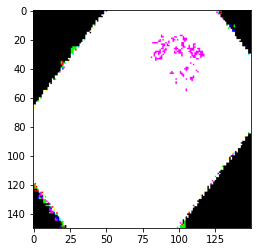

In [58]:
# Observando as images após a normalização
plt.imshow(images[100])

In [209]:
# Embaralhar os dados e separar novos conjuntos de  treinamento (80%), validação (10%) e teste (10%)
images, labels = shuffle(images, labels, random_state=10)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


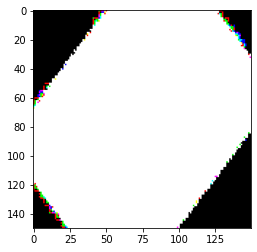

In [62]:
plt.imshow(train_images[2232])

In [60]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Quantidade de imagens para treinamento: {}".format(n_train))
print("Quantidade de imagens para validação: {}".format(n_val))
print("Quantidade de imagens para teste: {}".format(n_test))

print("Formato das imagens de treinamento: {}".format(train_images.shape))
print("Labels das imagens de treinamento: {}".format(train_labels.shape))
print("Formato das imagens de validação: {}".format(val_images.shape))
print("Labels das imagens de validação: {}".format(val_labels.shape))
print("Formato das imagens de teste: {}".format(test_images.shape))
print("Labels das imagens de teste: {}".format(test_labels.shape))


Quantidade de imagens para treinamento: 2233
Quantidade de imagens para validação: 280
Quantidade de imagens para teste: 279
Formato das imagens de treinamento: (2233, 150, 150, 3)
Labels das imagens de treinamento: (2233,)
Formato das imagens de validação: (280, 150, 150, 3)
Labels das imagens de validação: (280,)
Formato das imagens de teste: (279, 150, 150, 3)
Labels das imagens de teste: (279,)


In [21]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)


(2233, 150, 150, 3)
(279, 150, 150, 3)
(280, 150, 150, 3)


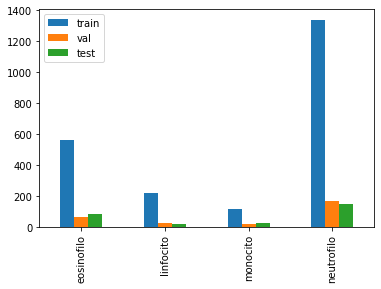

In [63]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

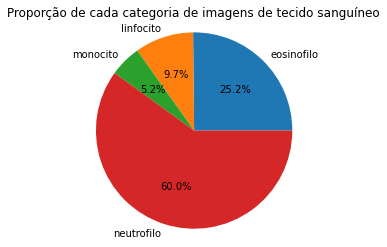

In [64]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporção de cada categoria de imagens de tecido sanguíneo')
plt.show()

**Normalização dos dados**

In [65]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

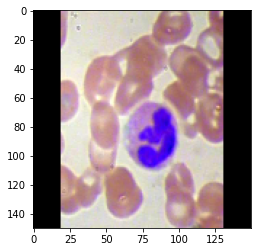

In [68]:
# Mais uma verificação da img após a normalização
plt.imshow(train_images[2000])

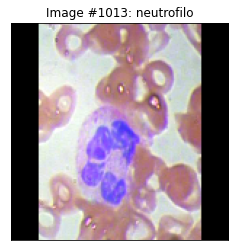

In [71]:
# Checagem com imagem aleatória
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image(class_names, train_images, train_labels)

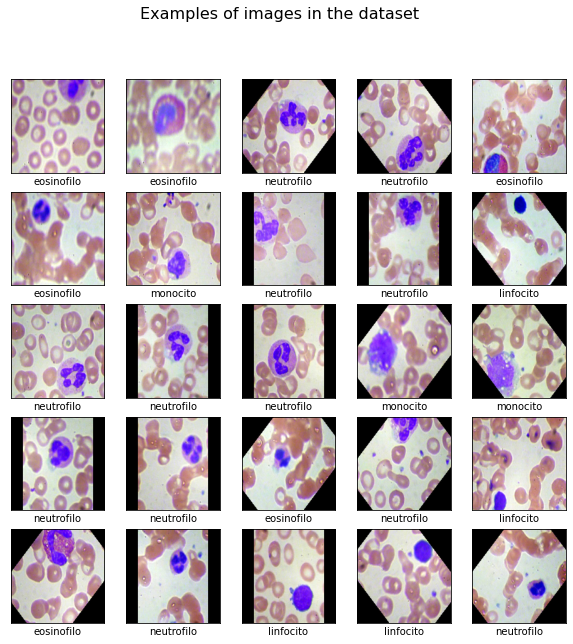

In [119]:
# Checagem com exemplos de imagens de cada categoria
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

**Construção do modelo**

In [ ]:
model = Sequential()

# Primeira camada concolucional
model.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Segunda camada concolucional
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Terceira camada concolucional
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Quarta camada concolucional
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Quinta camada concolucional
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Camada (Fully Connected ) FC para classificar as features aprendidas
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.7))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.3))

# Camada de saída
model.add(Dense(units = 4 , activation = 'softmax'))

# Compilação
model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

# Callback
checkpoint = ModelCheckpoint(filepath='best_model_epoc_50.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# treinamento
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 50, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])

## Avaliação

In [185]:
# Avaliação dp desempenh da CNN
def plotAccucaria(history):
    epochs = [i for i in range(50)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Acurácia de treinamento')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Acurária de validação')
    ax[0].set_title('Acurácia de treinamento e validação')
    ax[0].legend()
    ax[0].set_xlabel("Épocas")
    ax[0].set_ylabel("Acurácia")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Perda no treinamento')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Perda na validação')
    ax[1].set_title('Perdas no treinamento e validação')
    ax[1].legend()
    ax[1].set_xlabel("Épocas")
    ax[1].set_ylabel("Perdas")
    plt.show()

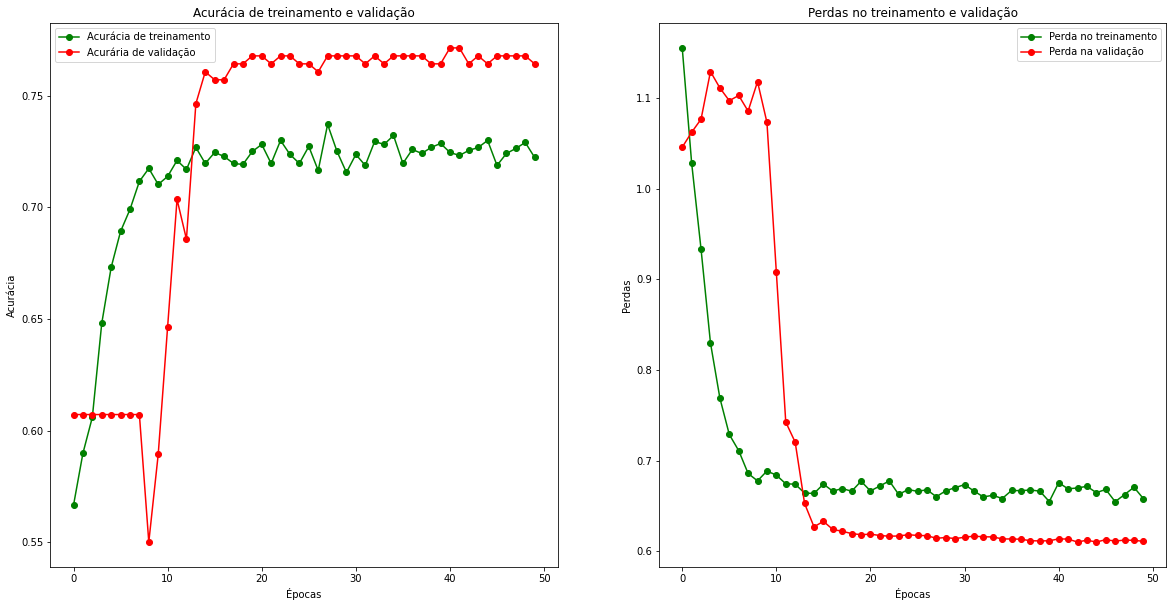

In [186]:
# Usando a função plotAcuracia
plotAccucaria(history)


In [187]:
# Resultados do treinamento da CNN

results = model.evaluate(test_images, test_labels)

print("Perda do modelo = ", results[0])
print("Acurácia do modelo = ", results[1]*100, "%")

9/9 [==============================] - 0s 16ms/step - loss: 0.7229 - accuracy: 0.6703
Perda do modelo =  0.7228918671607971
Acurácia do modelo =  67.02508926391602 %


In [188]:
# Salvar o modelo
#model.save('BloodModel_20210708.h5') #Acurácia do modelo: 22.93%
# Aumento do número de epochs de 10 para 20
#model.save('best_model_epoc_20.hdf5') #Acurácia do modelo: 74.19%
# Aumento do número de epochs de 10 para 50
model.save('best_model_epoc_50.hdf5') #Acurácia do modelo: 67.025%


In [115]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([3, 3, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3])

In [116]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['eosinófilo (Class 0)', 'linfócito (Class 1)', 'monócito (Class 2)', 'neutrófilo (Class 3)']))

                      precision    recall  f1-score   support

eosinófilo (Class 0)       0.57      0.79      0.66        84
 linfócito (Class 1)       0.83      0.24      0.37        21
  monócito (Class 2)       0.00      0.00      0.00        27
neutrófilo (Class 3)       0.87      0.93      0.89       147

            accuracy                           0.74       279
           macro avg       0.57      0.49      0.48       279
        weighted avg       0.69      0.74      0.70       279



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,66,1,0,17
1,16,5,0,0
2,23,0,0,4
3,11,0,0,136


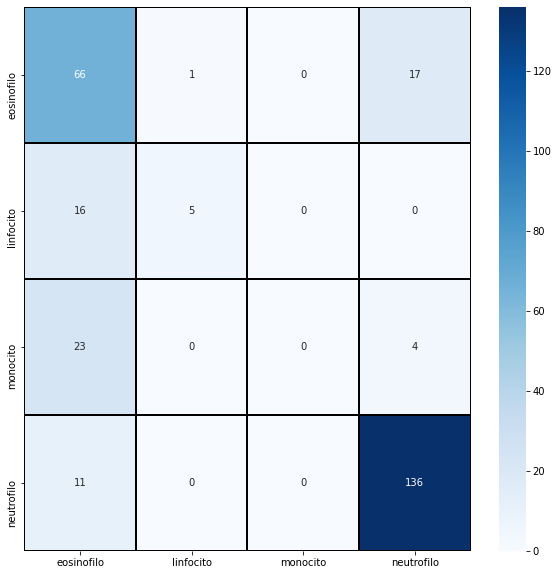

In [118]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)